<a href="https://colab.research.google.com/github/janetytli/aetherAI_MLE/blob/main/Final%20Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('./drive/MyDrive/co_lab_MLE/kaggle/dog_cat/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./drive/MyDrive/co_lab_MLE/kaggle/dog_cat/sampleSubmission.csv
./drive/MyDrive/co_lab_MLE/kaggle/dog_cat/test1.zip
./drive/MyDrive/co_lab_MLE/kaggle/dog_cat/train.zip


In [17]:
# data extraction
base_dir = "./drive/MyDrive/co_lab_MLE/kaggle/dog_cat/"
train_dir = os.path.join(base_dir, "train.zip")
test_dir = os.path.join(base_dir, "test1.zip")

import zipfile
with zipfile.ZipFile(train_dir,"r") as z:
    z.extractall()

with zipfile.ZipFile(test_dir,"r") as z:
    z.extractall()

## Import libs

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
#from keras.preprocessing import image
import keras.utils as image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

Training Dataset prepare

In [19]:
images = os.listdir("./train")
data = pd.DataFrame(images)
data = data.rename(columns={0: "image"})
data['image'] = data['image'].apply(lambda x: "./train/"+x)
data['label'] = data['image'].apply(lambda x: 0 if 'cat' in x else 1)
data.head()

,image,label
0,./train/cat.7673.jpg,0
1,./train/dog.2997.jpg,1
2,./train/dog.11520.jpg,1
3,./train/dog.4568.jpg,1
4,./train/cat.8025.jpg,0


In [20]:
train_image = []
for i in tqdm(range(data.shape[0])):
    img = image.load_img(data['image'][i], target_size=(64,64,1), color_mode = "grayscale")
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)


100%|██████████| 25000/25000 [01:24<00:00, 296.08it/s]


In [21]:
y=data['label'].values

Model architecture design

In [22]:
from keras.layers import LeakyReLU
def train(batch_norm=False):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3,3), input_shape=(64, 64, 1), activation=LeakyReLU(alpha=0.1), kernel_initializer='he_normal'))
    model.add(Conv2D(64, kernel_size=(3,3), input_shape=(62, 62, 64), activation=LeakyReLU(alpha=0.1), kernel_initializer='he_normal'))  # 0.8806 add layer and modify activation fn
    # add batch_norm 0.8882
    if batch_norm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=3))
    model.add(Dropout(0.5)) #0.4->0.5 82->83
    model.add(Conv2D(32, kernel_size=(3,3), activation = LeakyReLU(alpha=0.1))) #relu -> lrelu 0.8356
    if batch_norm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=3))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation= LeakyReLU(alpha=0.1))) #relu -> lrelu 0.8356
    model.add(Dropout(0.5)) #0.4->0.5 82->83
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])    
    return model

In [23]:
# training the model on all of input data
model = train(batch_norm=True)
train_on_full_data = model.fit(X, y, epochs=25 )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization_2 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 18, 32)       

draw training curve

In [24]:
# training set accuacy plot function design
import matplotlib.pyplot as plt

def plot_acc_loss(model_training_history, keyword ="accuracy", label=""):
    # summarize history for accuracy
    plt.plot(model_training_history.history[keyword])
    title = f'model {keyword} {label}'.strip()
    plt.title(title)
    plt.ylabel(keyword)
    plt.xlabel('epoch')
    plt.legend(['train',], loc='upper left')
    plt.show()

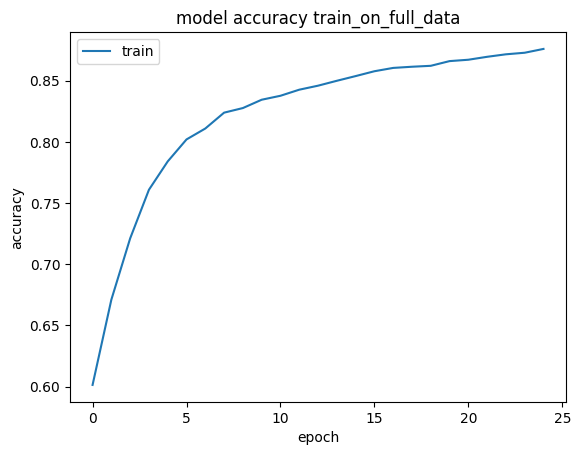

In [25]:
plot_acc_loss(train_on_full_data, label="train_on_full_data")

Test data set test on trained model

In [26]:
test = os.listdir("./test1")
df = pd.DataFrame(test)

df = df.rename(columns={0: "image"})
df['id'] = df['image'].apply(lambda x: x.split('.')[0])
df['image'] = df['image'].apply(lambda x: "./test1/"+x)
df['label'] = df['image'].apply(lambda x: 0 if 'cat' in x else 1)
df.head()

,image,id,label
0,./test1/9.jpg,9,1
1,./test1/7122.jpg,7122,1
2,./test1/6412.jpg,6412,1
3,./test1/12498.jpg,12498,1
4,./test1/7558.jpg,7558,1


In [27]:
val_image = []
for i in tqdm(range(df.shape[0])):
    img = image.load_img(df['image'][i], target_size=(64,64,1), color_mode = "grayscale")
    img = image.img_to_array(img)
    img = img/255
    val_image.append(img)
X_val = np.array(val_image)

100%|██████████| 12500/12500 [00:36<00:00, 338.19it/s]


In [28]:
y_pred = model.predict(X_val)
df['pred']=y_pred
df['pred'] = df['pred'].apply(lambda x: 0 if x<0.5 else 1)
n=len(df.pred)
acc=0
fa=0
for i in range (0,n):
  if df.pred[i] == df.label[i]:
    acc = acc + 1
  else:
    fa = fa + 1

print(acc, fa)
print('accuracy=', acc/(acc + fa))

391/391 [==============================] - 2s 5ms/step
7542 4958
accuracy= 0.60336


Draw confusion matrix

In [29]:
from sklearn.metrics import classification_report

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

CONFUSION MATRIX
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.60      0.75     12500

    accuracy                           0.60     12500
   macro avg       0.50      0.30      0.38     12500
weighted avg       1.00      0.60      0.75     12500

**************************************************************
Confusion matrix, without normalization
[[   0    0]
 [4958 7542]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


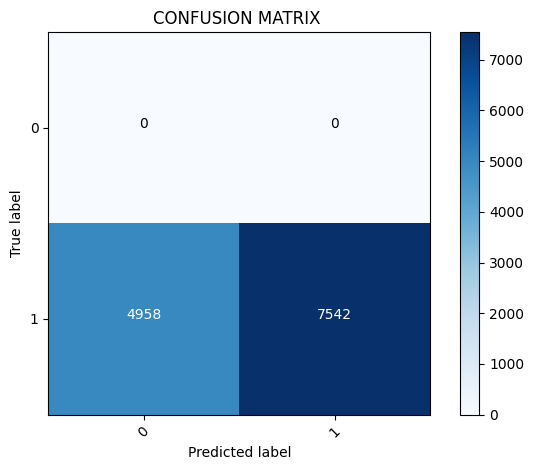

In [30]:
target_names = ['0','1']
print ("CONFUSION MATRIX")
print(classification_report(df.label, df.pred, target_names=target_names))
print ("**************************************************************")

plt.figure()
cnf_matrix = confusion_matrix(df.label,df.pred)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=False,
                    title="CONFUSION MATRIX ")